# Mixture Resnet18 CIFAR10 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
%run result_summary.ipynb
%run ../externals/deep_pnml/notebooks/plot_functions.ipynb
sys.path.insert(0, '../src/')
sys.path.insert(0, '../externals/deep_pnml/src')
sys.path.insert(0, '../externals/deep_pnml/notebooks/')


output_path =  ../output/figures
plt = single_column_plt_params(plt)
plt = double_column_plt_params(plt)


In [2]:
from distributions_metrics import calc_performance_in_out_dist
from analyze_utilities import load_results_to_df, load_dict_from_file_list
from mixture_utilities import create_mixture_df


plt = double_column_plt_params(plt)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
plt = double_column_plt_params(plt)

# PNML Vs. ERM Performence
PNML is as training is as following:
1. Train base model with all trainset
2. Freeze first layers (only enable updates of layer 5,6 in resnet20)
3. For each test sample:
    1. For each label:
        1. Add the test sample with the label to trainset
        2. Train for 10 epochs the model
        3. Keep probability of the test sample label which it was trained with
    2. Take all save probabilities and normalize them.
    3. Report the new probability assignment

In [7]:
# Print acc and mean loss
result_df, statistics_df = load_results_to_df(files_nml_2_layers)
print(statistics_df.transpose())
print('Number of testsamples: ',result_df.shape[0])

          acc  mean loss  std loss  mean entropy
nml    0.9184   0.167210  0.313679      0.197706
erm    0.9183   0.194359  0.821636      0.024840
genie  0.9875   0.027294  0.230810      0.024752
Number of testsamples:  10000


In [8]:
# Load bla
results_dict = load_dict_from_file_list(files_nml_2_layers)
mixture_df = create_mixture_df(results_dict)

100%|██████████| 10000/10000 [01:53<00:00, 88.34it/s]


In [9]:
statistics_df['Mixture'] = [mixture_df['is_correct'].mean(),mixture_df['loss'].mean(),mixture_df['loss'].std() ,
                            mixture_df['entropy'].mean()]
print(statistics_df.transpose())

            acc  mean loss  std loss  mean entropy
nml      0.9184   0.167210  0.313679      0.197706
erm      0.9183   0.194359  0.821636      0.024840
genie    0.9875   0.027294  0.230810      0.024752
Mixture  0.9182   0.130127  0.356770      0.143031


In [10]:
mixture_df['capacity'].mean()

0.052227198194001026

# Inspect loss

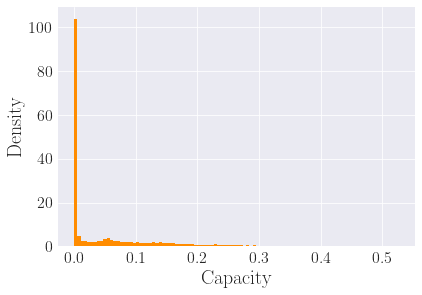

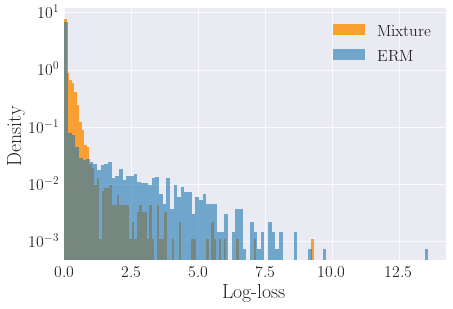

In [11]:
# Capacity histogram
bins = 100
plt.hist(mixture_df['capacity'].values.tolist(), density=True, bins=bins, color='darkorange')
plt.title('Capacity Histogram') if is_plot_title else None
plt.xlabel('Capacity')
plt.ylabel('Density')
# plt.savefig(os.path.join(output_path, 'figure_regret_hist.jpg'), dpi=200,
#             bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# logloss histogram
bins = 100
plt.hist(mixture_df['loss'].values.tolist(), bins=bins, alpha=0.8,
         label='Mixture', density=True, color='darkorange')
plt.hist(result_df['erm_loss'].values.tolist(), bins=bins,
         alpha=0.6, label='ERM', density=True)
plt.title('Logloss Histogram') if is_plot_title else None
plt.xlabel('Log-loss')
plt.ylabel('Density')
plt.yscale('log')
plt.xlim(left=0)
plt.legend()
plt.savefig(os.path.join(output_path, 'figure_mixture_logloss_capacity_hist.pdf'), dpi=300,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

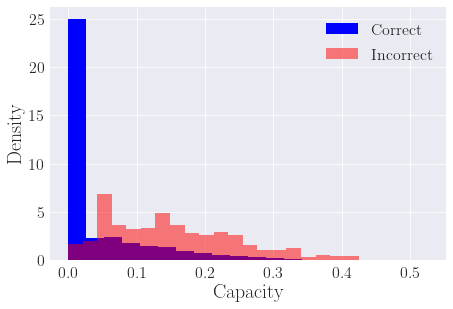


Correct = 9182, Incorrect = 818 
Mean [correct, incorrect]=[0.04331193429422489, 0.1523004905262071]


In [12]:
# Plot histogram of correct vs incorrect
correct_capacity = mixture_df['capacity'][mixture_df['is_correct'] == True].values.tolist()
incorrect_capacity = mixture_df['capacity'][mixture_df['is_correct'] == False].values.tolist()

bins = 20

plt.hist(correct_capacity, alpha=1, bins=bins, density=True, color='blue', label='Correct')
plt.hist(incorrect_capacity, alpha=0.5, bins=bins, density=True, color='red', label='Incorrect')
plt.title(
    'Capacity Histogram with Correct and Incorrect Separation') if is_plot_title else None
plt.xlabel('Capacity')
plt.ylabel('Density')
plt.legend()
plt.savefig(os.path.join(output_path, 'figure_mixture_correct_incorrect_capacity_hist.pdf'), dpi=300,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

print()
print('Correct = %d, Incorrect = %d ' %
      (len(correct_capacity), len(incorrect_capacity)))
print('Mean [correct, incorrect]={}'.format(
    [np.mean(correct_capacity), np.mean(incorrect_capacity)]))

# Compose Capacity based Estimator

In [13]:
acc_list = []
acc_erm_list = []
cdf_list = []
nml_thresh_loss_list = []
erm_thresh_loss_list = []

max_prob = result_df[['erm_' + str(x) for x in range(10)]].max(axis=1)
max_prob_sorted_df = pd.DataFrame({
    'max_prob': max_prob,
    'loss': result_df['erm_loss'],
    'is_correct': result_df['erm_is_correct']}).sort_values(by='max_prob', ascending=False)

capacity_sorted_df = pd.DataFrame({
    'capacity': mixture_df['capacity'],
    'loss': mixture_df['loss'],
    'is_correct': mixture_df['is_correct']}).sort_values(by=['capacity'], ascending=True)
num_samples_total = mixture_df.shape[0]

In [14]:
num_samples_list = np.arange(1, mixture_df.shape[0], 10)
capacity_acc_list = []
capacity_loss_list = []

max_prob_acc_list = []
max_prob_loss_list = []
for num_samples in num_samples_list:
    capacity_acc_list.append(capacity_sorted_df[:num_samples]['is_correct'].astype(int).mean())
    capacity_loss_list.append(capacity_sorted_df[:num_samples]['loss'].mean())
    
    max_prob_acc_list.append(max_prob_sorted_df[:num_samples]['is_correct'].astype(int).mean())
    max_prob_loss_list.append(max_prob_sorted_df[:num_samples]['loss'].mean())

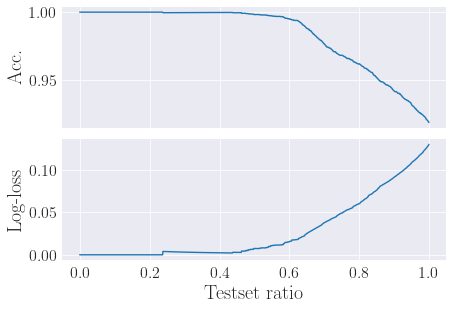

In [15]:
fig,axs = plt.subplots(2,1, facecolor='w')
ax = axs[0]
# ax.plot(num_samples_list/num_samples_total, max_prob_acc_list, label='Max Prob')
ax.plot(num_samples_list/num_samples_total, capacity_acc_list, label='Mixture')
ax.set_ylabel('Acc.')

labels = [item.get_text() for item in ax.get_xticklabels()]
empty_string_labels = [''] * len(labels)
ax.set_xticklabels(empty_string_labels)

ax = axs[1]
# ax.plot(num_samples_list/num_samples_total, max_prob_loss_list, label='Max Prob')
ax.plot(num_samples_list/num_samples_total, capacity_loss_list, label='Mixture')
ax.set_xlabel('Testset ratio')
ax.set_ylabel('Log-loss')
fig.tight_layout()
plt.savefig(os.path.join(output_path, 'figure_mixture_capacity_based_classifier.pdf'),
            dpi=300, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()